In [2]:
import networkx as nx
import itertools
from numpy.linalg import eig
import numpy as np
from collections import defaultdict 
from gudhi.representations import PersistenceImage
import matplotlib.pyplot as plt
import warnings

In [3]:
warnings.filterwarnings('ignore')
master_list = []

In [4]:
def sort_each_list(data_dict):
    sorted_data = {}
    for key, value in data_dict.items():
        sorted_data[key] = [sorted(lst) for lst in value]
    return sorted_data

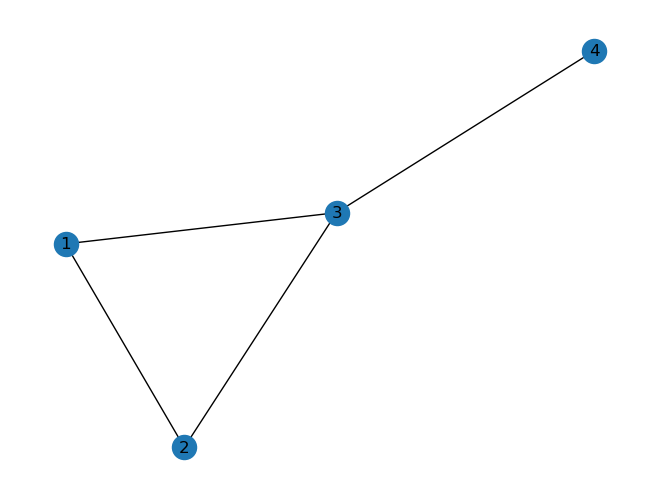

In [5]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4])
G.add_edges_from([(1,2),(1,3),(2,3),(3,4)])
G = nx.convert_node_labels_to_integers(G, first_label=1, ordering='default', label_attribute=None)
nx.draw(G, with_labels=True)

In [6]:
all_paths = []
nodes_combs = itertools.combinations(G.nodes, 2)

required_max_path_length = 3 # (inferior or equal to)

for source, target in nodes_combs:
    paths = nx.all_simple_paths(G, source=source, target=target, cutoff=required_max_path_length)
    for path in paths:
        # if path not in all_paths and path[::-1] not in all_paths:
        all_paths.append(path)
print(all_paths)

[[1, 2], [1, 3, 2], [1, 2, 3], [1, 3], [1, 2, 3, 4], [1, 3, 4], [2, 1, 3], [2, 3], [2, 1, 3, 4], [2, 3, 4], [3, 4]]


In [8]:
Lap = nx.laplacian_matrix(G)
A_lapl = nx.normalized_laplacian_matrix(G).toarray()
A_lapl

array([[ 1.        , -0.5       , -0.40824829,  0.        ],
       [-0.5       ,  1.        , -0.40824829,  0.        ],
       [-0.40824829, -0.40824829,  1.        , -0.57735027],
       [ 0.        ,  0.        , -0.57735027,  1.        ]])

In [14]:
eigen_values,eigen_vectors=eig(A_lapl)
eigen_values, eigen_vectors

(array([0.        , 0.77128645, 1.5       , 1.72871355]),
 array([[-5.00000000e-01, -4.36209951e-01,  7.07106781e-01,
          2.44378557e-01],
        [-5.00000000e-01, -4.36209951e-01, -7.07106781e-01,
          2.44378557e-01],
        [-6.12372436e-01,  2.89867343e-01,  1.47411531e-15,
         -7.35511335e-01],
        [-3.53553391e-01,  7.31723091e-01, -1.64100273e-15,
          5.82736062e-01]]))

In [15]:
eigen_values = np.real(eigen_values)
eigen_vectors = np.real(eigen_vectors)

eigen_lst = eigen_values.tolist() 
eigen_lst_rounded = [ '%.5f' % elem for elem in eigen_lst ]
eigen_lst_rounded

['0.00000', '0.77129', '1.50000', '1.72871']

In [21]:
# indicies of duplicates
dup_indecies= dict((x, indices(eigen_lst_rounded, x)) for x in set(eigen_lst_rounded) if eigen_lst_rounded.count(x) > 1)
dup_list =list(set().union(*dup_indecies.values()))
dup_list

[]

In [22]:
eigen_vectors = np.array(eigen_vectors)
# delete the eigen vectors corresponding to the eigen values with multiplicity >=2
eigen_vectors = np.delete(eigen_vectors, dup_list, axis=1)
eigen_vectors

array([[-5.00000000e-01, -4.36209951e-01,  7.07106781e-01,
         2.44378557e-01],
       [-5.00000000e-01, -4.36209951e-01, -7.07106781e-01,
         2.44378557e-01],
       [-6.12372436e-01,  2.89867343e-01,  1.47411531e-15,
        -7.35511335e-01],
       [-3.53553391e-01,  7.31723091e-01, -1.64100273e-15,
         5.82736062e-01]])

In [23]:
# add up all teh values in each row corresponding to 
# the eigen vector values for the n verices
eigen_vectors_absol = np.absolute(eigen_vectors)
sum_eigen_vectors = np.sum(eigen_vectors_absol, axis = 1)
sum_eigen_vectors

array([1.88769529, 1.88769529, 1.63775111, 1.66801254])

In [24]:
A = nx.adjacency_matrix(G)
adjaceny_matrix = A.todense()
adjaceny_matrix

matrix([[0, 1, 1, 0],
        [1, 0, 1, 0],
        [1, 1, 0, 1],
        [0, 0, 1, 0]], dtype=int32)

In [25]:
# row based Multiplication
adjXeigen= np.multiply(adjaceny_matrix, sum_eigen_vectors)
adjXeigen

matrix([[0.        , 1.88769529, 1.63775111, 0.        ],
        [1.88769529, 0.        , 1.63775111, 0.        ],
        [1.88769529, 1.88769529, 0.        , 1.66801254],
        [0.        , 0.        , 1.63775111, 0.        ]])

In [26]:
adjXeigen = adjXeigen /sum_eigen_vectors[:,None]
adjXeigen

matrix([[0.        , 1.        , 0.86759294, 0.        ],
        [1.        , 0.        , 0.86759294, 0.        ],
        [1.15261426, 1.15261426, 0.        , 1.01847743],
        [0.        , 0.        , 0.98185779, 0.        ]])

In [27]:
# Add up all the values in each row
eigen_weights=np.sum(adjXeigen,axis=1)  
eigen_weights

matrix([[1.86759294],
        [1.86759294],
        [3.32370595],
        [0.98185779]])

In [28]:
eigen_weights = eigen_weights + sum_eigen_vectors[:,None]
eigen_weights

matrix([[3.75528823],
        [3.75528823],
        [4.96145706],
        [2.64987034]])

In [8]:
pairwise_dict = defaultdict(list)

for pathi in all_paths: 
    s= np.array(eigen_weights[pathi[0]-1][0]).item()
    e= np.array(eigen_weights[pathi[-1]-1][0]).item()
    s = round(s, 4)
    e = round(e, 4)
    pairwise_dict[len(pathi)-1].append([s,e])
    
pairwise_dict = sort_each_list(pairwise_dict)

In [75]:
pairwise_dict

{1: [[3.8961, 5.0789],
  [3.9397, 5.0789],
  [3.9397, 5.0789],
  [2.914, 3.8961],
  [3.9397, 3.9397]],
 2: [[3.9397, 5.0789],
  [3.9397, 5.0789],
  [2.914, 5.0789],
  [3.8961, 3.9397],
  [3.8961, 3.9397],
  [3.9397, 3.9397]],
 3: [[3.8961, 3.9397], [3.8961, 3.9397], [2.914, 3.9397], [2.914, 3.9397]]}

## calculate the min and the max 

In [76]:
x_min = y_min = 1000000000
x_max = y_max = 0
pairwise_dict_numpy = defaultdict(list)

for j in pairwise_dict:                
    pairwise_dict_numpy[j] = np.array(pairwise_dict[j]).astype(np.float16)
    x_min = min(x_min,np.min(pairwise_dict_numpy[j][:,0]))
    x_max = max(x_max,np.max(pairwise_dict_numpy[j][:,0]))
    y_min = min(y_min,np.min(pairwise_dict_numpy[j][:,1]))
    y_max = max(y_max,np.max(pairwise_dict_numpy[j][:,1]))

master_list.append(pairwise_dict)

## Construct the Persistance diagram

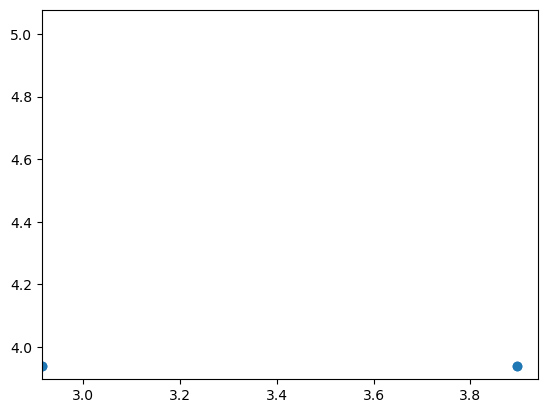

In [77]:
for index, pw_dict in enumerate(master_list,0):

    pairwise_dict_np = defaultdict(list)

    for j,  val in enumerate(pw_dict,1):     
        pairwise_dict_np[j] = np.array(pw_dict[j]).astype(np.float16)
        plt.clf()
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        x, y = pairwise_dict_np[j].T
        plt.scatter(x, y)     

In [78]:
pi = PersistenceImage(resolution=[40,40], im_range=[x_min, x_max, y_min, y_max])
pi.fit([np.array(pw_dict[j]).astype(np.float16)])
vec = pi.transform([np.array(pw_dict[j]).astype(np.float16)])

In [79]:
vec

array([[5.27972133e-03, 5.28096098e-03, 5.27862907e-03, ...,
        5.47945134e-05, 5.34176953e-05, 5.20401208e-05]])